In [2]:
import sys; sys.path.append('../..')
import numpy as np, elastic_rods
from bending_validation import suppress_stdout
from linkage_vis import LinkageViewer

l = elastic_rods.RodLinkage('data/AsymmWingsPointy/flat_opt.msh')
driver=l.centralJoint()

mat = elastic_rods.RodMaterial('Rectangle', 20000, 0.3, [12,8], stiffAxis=elastic_rods.StiffAxis.D1)
l.setMaterial(mat)

l.setPerSegmentRestLength(np.loadtxt('data/AsymmWingsPointy/design_parameters.txt'))

jdo = l.dofOffsetForJoint(driver)
fixedVars = list(range(jdo, jdo + 6)) # fix rigid motion for a single joint
# fixedVars.append(jdo + 6) # constrain angle at the driving joint
with suppress_stdout(): elastic_rods.compute_equilibrium(l, fixedVars=fixedVars)

view = LinkageViewer(l, width=1024, labelOffset=-0.5)
view.show()

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

## Analyze Hessian spectrum

In [3]:
import compute_vibrational_modes
fixedVarsWithoutActuator = fixedVars[:]
lambdas, modes = compute_vibrational_modes.compute_vibrational_modes(l, fixedVars=[], mtype=compute_vibrational_modes.MassMatrixType.FULL, n=16, sigma=-1e-6)

import mode_viewer, importlib
importlib.reload(mode_viewer);
mview = mode_viewer.ModeViewer(l, modes, lambdas, amplitude=5.0)
mview.show()

## Analyze Deployment Path Uniqueness

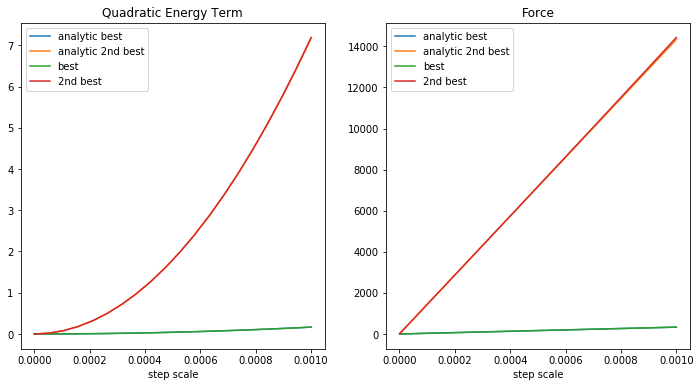

In [4]:
import deployment_path_analysis
dpa = deployment_path_analysis.deploymentPathAnalysis(l)
deployment_path_analysis.validateEnergyIncrements(l, epsMax=1e-2)

In [7]:
m = deployment_path_analysis.deploymentModeViewer(l)
m.setAmplitude(0.2)
m.show()

In [6]:
deployAngle = 2.0
openingAngles, stiffnessGaps = deployment_path_analysis.stiffnessGapThroughoutDeployment(l, deployAngle, 50)
view.update()

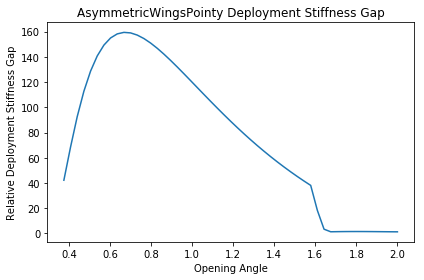

In [15]:
from matplotlib import pyplot as plt
plt.plot(openingAngles, stiffnessGaps)
plt.ylabel('Relative Deployment Stiffness Gap')
plt.xlabel('Opening Angle')
plt.title('AsymmetricWingsPointy Deployment Stiffness Gap')
plt.tight_layout()
plt.savefig('stiffness_gap_asymmetric_wings_pointy.pdf')
plt.show()

In [16]:
stiffnessGaps[-1]

1.258797686318566

## "Stress" analysis, fabrication data

In [ ]:
# Compute maximum "stress" appearing at any rod vertex in the structure
max([max(segmentStress) for segmentStress in l.rodStresses()[1]])

In [ ]:
# Compute average "stress" appearing over all rod vertices in the structure
np.mean(sum(l.rodStresses()[1], []))

In [ ]:
# Output fabrication data
from linkage_utils import writeRodSegments
writeRodSegments(l,'rod_segments_meshID_1935b524-e979-4340-9245-326f69b6eae0.txt', zeroBasedIndexing=True)
np.savetxt('restlen_meshID_1935b524-e979-4340-9245-326f69b6eae0.txt',l.getPerSegmentRestLength())

## Deployment, energy balance plots

In [ ]:
from open_linkage import open_linkage
def equilibriumSolver(tgtAngle, l, opts, fv):
    opts.beta = 1e-8
    opts.gradTol = 1e-4
    opts.useIdentityMetric = False
    return elastic_rods.compute_equilibrium(l, tgtAngle, options=opts, fixedVars=fv)
# open_linkage(l, driver, 2 * np.pi/3, 25, view, zPerturbationEpsilon=0, equilibriumSolver=equilibriumSolver, maxNewtonIterationsIntermediate=20, verbose=10, useTargetAngleConstraint=False);
cr, actuationForces, tgtAngles = open_linkage(l, driver, 2.0 - l.averageJointAngle, 50, view, zPerturbationEpsilon=0, equilibriumSolver=equilibriumSolver, maxNewtonIterationsIntermediate=20, verbose=10, useTargetAngleConstraint=True);

In [ ]:
cr[1].energy

In [ ]:
from deploy_energy_plots import deploymentEnergyPlot
deploymentEnergyPlot(tgtAngles, cr)

In [ ]:
from write_render_files import writeRenderFiles
writeRenderFiles(l, 'AsymPointyDataFlat', 'asymPointy_Fab')